In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import networkx as nx

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_origin = pd.read_feather('data/od_origin.feather')
df_des = pd.read_feather('data/od_des.feather')

In [3]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs(epsg=27700)

ward_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
ward_shp = ward_shp.to_crs(epsg=27700)

borough_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
borough_shp = borough_shp.to_crs(epsg=27700)

msoa_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
msoa_shp = msoa_shp.to_crs(epsg=27700)

london_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/london_boundary.shp")
london_shp = london_shp.to_crs(epsg=27700)

In [4]:
od_count = pd.read_feather('data/od_count.feather')
od_count_weekday = pd.read_feather('data/od_count_weekday.feather')
od_count_weekend = pd.read_feather('data/od_count_weekend.feather')

In [5]:
similarity_network = pd.read_csv('output/similarity_network.csv')

In [6]:
similarity_network.head(2)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,...,normalized_degree_weekend,pagerank,top_pr_similarity,pagerank_weekday,pagerank_weekend,top_flow_similarity,top_flow_similarity_weekday,top_pr_similarity_weekday,top_flow_similarity_weekend,top_pr_similarity_weekend
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,...,0.132143,0.004587,0.376945,0.004778,0.003893,0.335838,0.225137,0.273009,0.736415,0.736239
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,...,0.024877,0.000709,0.839007,0.000680,0.000801,0.865249,0.859439,0.828485,0.883005,0.882643


In [7]:
similarity_network_selected = similarity_network[['MSOA11CD',
                                                  'top_pr_similarity',
                                                  'top_pr_similarity_weekday','top_pr_similarity_weekend']]

In [8]:
similarity_network_selected

,MSOA11CD,top_pr_similarity,top_pr_similarity_weekday,top_pr_similarity_weekend
0,E02000001,0.376945,0.273009,0.736239
1,E02000002,0.839007,0.828485,0.882643
2,E02000003,0.928380,0.927214,0.940969
3,E02000004,0.849044,0.844728,0.878889
4,E02000005,0.903113,0.904792,0.910589
...,...,...,...,...
978,E02006927,0.932368,0.930987,0.945249
979,E02006928,0.822952,0.812850,0.868997
980,E02006929,0.912550,0.924631,0.886612
981,E02006930,0.892608,0.884889,0.923125


In [9]:
# merge with msoa_shp
msoa_shp_similarity = msoa_shp.merge(similarity_network_selected, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
msoa_shp_similarity

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,top_pr_similarity,top_pr_similarity_weekday,top_pr_similarity_weekend
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",0.376945,0.273009,0.736239
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.839007,0.828485,0.882643
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",0.928380,0.927214,0.940969
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",0.849044,0.844728,0.878889
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.903113,0.904792,0.910589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.0,3338,2.5,"POLYGON ((541029.881 176265.023, 541101.997 17...",0.932368,0.930987,0.945249
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.0,2977,2.2,"MULTIPOLYGON (((538300.370 177956.632, 538290....",0.822952,0.812850,0.868997
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.4,3333,2.2,"POLYGON ((540054.366 179353.136, 540220.352 17...",0.912550,0.924631,0.886612
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.6,2876,2.3,"POLYGON ((539552.478 178604.042, 539533.000 17...",0.892608,0.884889,0.923125


In [10]:
# normalize the similarity
msoa_shp_similarity['top_pr_similarity'] = msoa_shp_similarity['top_pr_similarity']/msoa_shp_similarity['top_pr_similarity'].max()
msoa_shp_similarity['top_pr_similarity_weekday'] = msoa_shp_similarity['top_pr_similarity_weekday']/msoa_shp_similarity['top_pr_similarity_weekday'].max()
msoa_shp_similarity['top_pr_similarity_weekend'] = msoa_shp_similarity['top_pr_similarity_weekend']/msoa_shp_similarity['top_pr_similarity_weekend'].max()


In [11]:
msoa_shp_similarity['top_pr_dissimilarity'] = 1 - msoa_shp_similarity['top_pr_similarity']
msoa_shp_similarity['top_pr_dissimilarity_weekday'] = 1 - msoa_shp_similarity['top_pr_similarity_weekday']
msoa_shp_similarity['top_pr_dissimilarity_weekend'] = 1 - msoa_shp_similarity['top_pr_similarity_weekend']


In [12]:
msoa_shp_similarity

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,top_pr_similarity,top_pr_similarity_weekday,top_pr_similarity_weekend,top_pr_dissimilarity,top_pr_dissimilarity_weekday,top_pr_dissimilarity_weekend
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",0.403554,0.292526,0.778323,0.596446,0.707474,0.221677
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.898236,0.887712,0.933095,0.101764,0.112288,0.066905
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",0.993918,0.993499,0.994755,0.006082,0.006501,0.005245
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",0.908981,0.905117,0.929127,0.091019,0.094883,0.070873
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.966867,0.969474,0.962638,0.033133,0.030526,0.037362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.0,3338,2.5,"POLYGON ((541029.881 176265.023, 541101.997 17...",0.998187,0.997542,0.999280,0.001813,0.002458,0.000720
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.0,2977,2.2,"MULTIPOLYGON (((538300.370 177956.632, 538290....",0.881047,0.870959,0.918669,0.118953,0.129041,0.081331
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.4,3333,2.2,"POLYGON ((540054.366 179353.136, 540220.352 17...",0.976970,0.990731,0.937291,0.023030,0.009269,0.062709
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.6,2876,2.3,"POLYGON ((539552.478 178604.042, 539533.000 17...",0.955621,0.948148,0.975891,0.044379,0.051852,0.024109


In [13]:
msoa_shp_similarity.to_csv("output/msoa_similarity_network.csv")

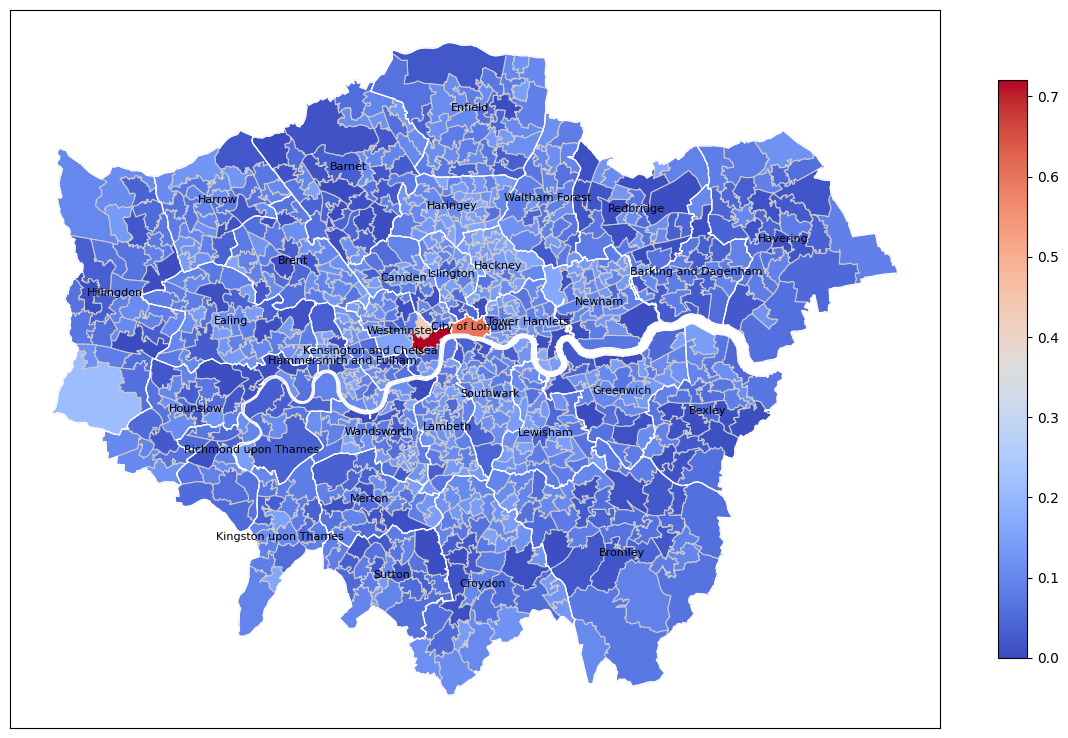

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp_similarity.plot(column='top_pr_dissimilarity', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
# label each borough with ;'NAME' columne
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')

plt.xticks([])
plt.yticks([])
plt.savefig('output/dissimilarity_network.jpg',dpi=600)
plt.show()


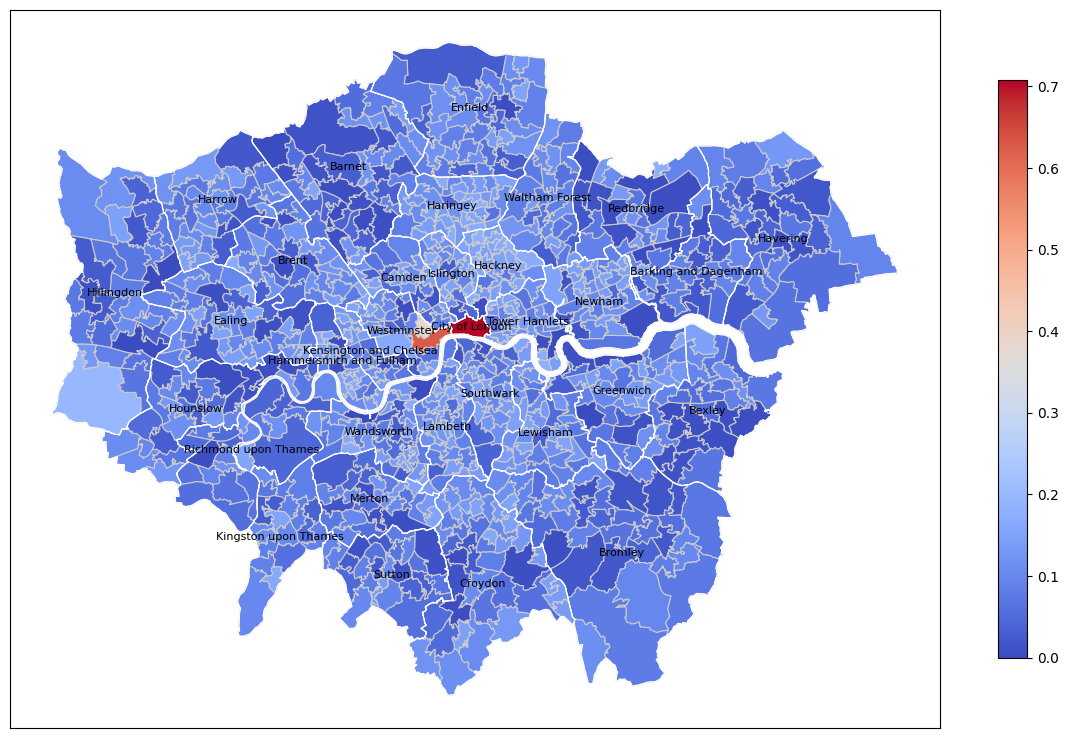

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp_similarity.plot(column='top_pr_dissimilarity_weekday', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')
    
plt.xticks([])
plt.yticks([])
plt.savefig('output/dissimilarity_network_weekday.jpg',dpi=600)
plt.show()


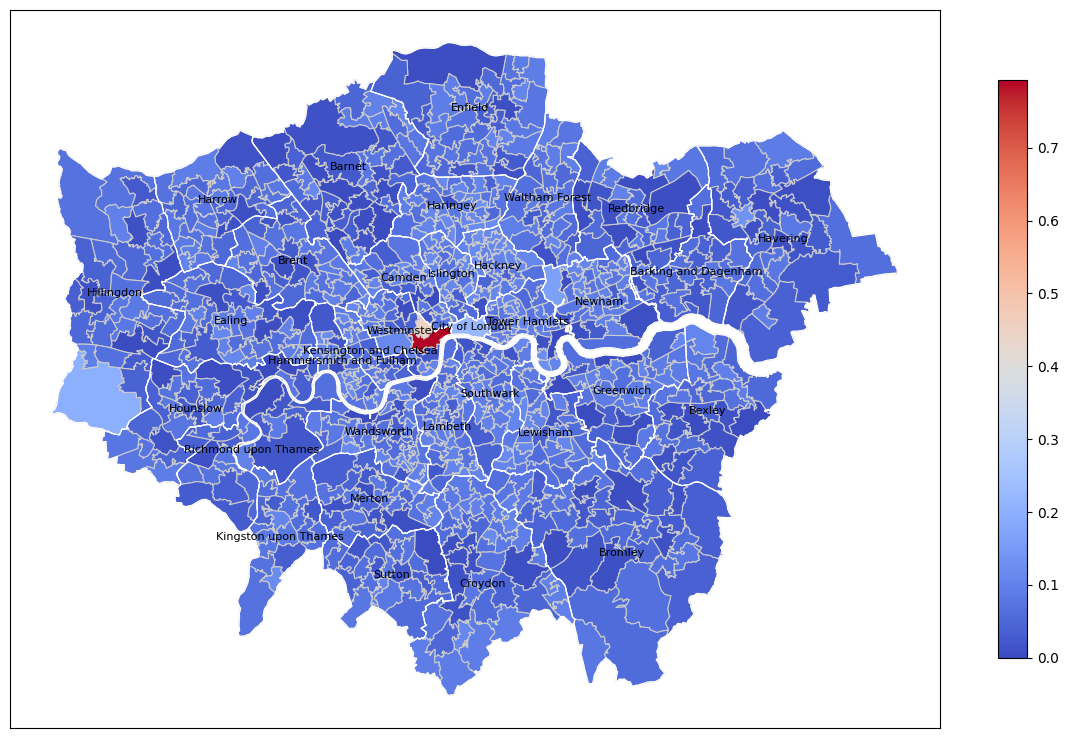

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp_similarity.plot(column='top_pr_dissimilarity_weekend', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')
    
plt.xticks([])
plt.yticks([])
plt.savefig('output/dissimilarity_network_weekend.jpg',dpi=600)
plt.show()
